# Sepsis prediction with Strats

- __lean version, run all cells immediate and once__

- physiological features only, no texts

- small dataset `pre_text_small`

## Hardware check

In [8]:
# gpu check
!nvidia-smi

Fri Mar 10 15:19:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:3A:00.0 Off |                    0 |
| N/A   34C    P0    38W / 300W |     21MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [1]:
# check number of cores
import multiprocessing

cores = multiprocessing.cpu_count() 
cores

80

## Environment Prep

In [2]:
! pip install pandas==1.3.4
! pip install tqdm==4.62.3
! pip install numpy==1.21.2
! pip install scikit-learn==0.24.2
! pip install scipy==1.7.1
! pip install setuptools==58.0.4
# # ! pip install sip==4.19.8
# # ! pip install six==1.16.0
# # ! pip install sqlite==3.36.0
# ! pip install tensorboard==1.15.0
# # ! pip install tensorflow==2.3.0
# ! pip install tensorflow-base==1.15.0
# ! pip install tensorflow-estimator==2.3.0
# # ! pip install tensorflow-gpu==1.15.0
# ! pip install tensorflow-gpu==2.3.0
! pip install tensorboard==1.15.0
! pip install tensorflow==2.3.0
! pip install tensorflow-base==1.15.0
! pip install tensorflow-estimator==2.3.0
! pip install tensorflow-gpu==1.15.0
# ! pip uninstall tensorflow tensorflow-gpu
# ! pip install tensorflow-gpu

Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-1.3.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.5 MB)
ERROR: Will not install to the user site because it will lack sys.path precedence to pandas in /pfs/data5/software_uc2/bwhpc/common/jupyter/tensorflow/2023-01-02/lib/python3.8/site-packages

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Using cached tqdm-4.62.3-py2.py3-none-any.whl (76 kB)
ERROR: Will not install to the user site because it will lack sys.path precedence to tqdm in /pfs/data5/software_uc2/bwhpc/common/jupyter/tensorflow/2023-01-02/lib/python3.8/site-packages

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Using cached nu

In [3]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.models import Model
# from tensorflow.keras import models
import pickle
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping
import pandas as pd
import json
import smart_cond as sc
# from google.colab import files

2023-03-11 13:51:08.904744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 13:51:14.020489: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-11 13:51:31.305046: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/bwhpc/common/devel/cuda/11.8/lib64
2023-03-11 13:51:31.318127: W tensorflow/compil

### Version Check

In [13]:
import tensorflow as tf
print(tf. __version__)

2.11.0


In [14]:
pickle.format_version

'4.0'

## Load Data

In [15]:
# connect to drive
#from google.colab import drive
#drive.mount('/content/drive')

In [16]:
#! unzip /content/drive/MyDrive/sepsis/strats_exp/data/sepsis_data/pre_text/pre_text_small.zip

In [4]:
# mortality data
data_path = 'sepsis_data/forecasting_exp1/sepsis_pretext_large.pkl'
pkl = pickle.load(open(data_path, 'rb'))
# data, oc, train_ind, valid_ind, test_ind = pd.read_pickle(open(data_path, 'rb'))

In [5]:
data = pkl[0]
data

,ts_ind,hour,variable,value,TABLE,mean,std
0,0,0.000000,Age,66.000000,N/A,64.053647,56.625699
1,0,0.000000,Gender,1.000000,N/A,0.438951,0.496263
2,0,0.033333,DBP,-0.517967,chart,59.766756,14.994705
3,0,0.033333,GCS_eye,0.679313,chart,3.274060,1.068640
4,0,0.033333,GCS_motor,0.515191,chart,5.271144,1.414728
...,...,...,...,...,...,...,...
81478793,57281,20.400000,MBP,0.195381,chart,78.552377,17.645628
81478794,57281,20.400000,O2 Saturation,-0.678068,chart,96.820961,4.160290
81478795,57281,20.400000,RR,0.179866,chart,26.278501,15.130729
81478796,57281,20.400000,SBP,-0.404061,chart,120.239648,25.341836


In [6]:
oc = pkl[1]
oc

,ts_ind,HADM_ID,SUBJECT_ID,in_hospital_sepsis
0,0,110404,268,1
1,1,188028,270,0
2,2,173727,271,0
3,3,164716,272,0
4,4,158689,273,0
...,...,...,...,...
57784,45535,143774,94944,0
57785,45536,123750,94950,0
57786,50475,196881,94953,0
57787,45537,118475,94954,0


### Preprocess Data

In [7]:
data.loc[data['variable'] == 'Antibiotics', 'value'] = 1

In [8]:
data.loc[data['variable'] == 'Blood Culture', 'value'] = 1

In [9]:
data.loc[data['variable'] == 'Mechanically ventilated', 'value'] = 1

In [10]:
# delete overlapped variable due to typo in mortality data
data = data[data['variable'] != 'vacomycin']

In [11]:
data = data.dropna()
oc = oc.dropna()

## Load Indices

### Genrate New Patient IDs

In [12]:
ids = oc['SUBJECT_ID'].tolist()
labels = oc['in_hospital_sepsis'].tolist()

new_patient_ids = []
new_labels = []

for i in range(len(labels)):
  # print(i)
  if ids[i] in new_patient_ids:
    continue
  else:
    new_patient_ids.append(ids[i])
    new_labels.append(labels[i])

In [13]:
from collections import Counter
# data ratio
Counter(labels)

Counter({1: 5288, 0: 51994})

#### Split train/val/test 

_on patient level: 64/16/20_

In [14]:
 from sklearn.model_selection import train_test_split

 x, x_test, y, y_test = train_test_split(new_patient_ids, new_labels, test_size=0.2, random_state=1)
 x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)

### Generate train_ind/val_ind/test_ind

In [15]:
# train
train_ind = []
ts_ind = oc['ts_ind'].tolist()

for i in range(len(ts_ind)):
  if ids[i] in x_train:
    train_ind.append(ts_ind[i])

In [16]:
test_ind = []

for i in range(len(ts_ind)):
  if ids[i] in x_test:
    test_ind.append(ts_ind[i])
    
# to np.array
test_ind = np.array(test_ind)

In [17]:
valid_ind = []

for i in range(len(ts_ind)):
  if ids[i] in x_val:
    valid_ind.append(ts_ind[i])

# to np.array
valid_ind = np.array(valid_ind)

## Load Forecasting Data into Matrices

In [18]:
pred_window = 2 # hours
obs_windows = range(20, 124, 4)

In [19]:
# Remove test patients.
data = data.merge(oc[['ts_ind', 'SUBJECT_ID']], on='ts_ind', how='left')
test_sub = oc.loc[oc.ts_ind.isin(test_ind)].SUBJECT_ID.unique()
data = data.loc[~data.SUBJECT_ID.isin(test_sub)]
oc = oc.loc[~oc.SUBJECT_ID.isin(test_sub)]
data.drop(columns=['SUBJECT_ID', 'TABLE'], inplace=True)
# Fix age.
data.loc[(data.variable=='Age')&(data.value>200), 'value'] = 91.4
# Get static data with mean fill and missingness indicator.
static_varis = ['Age', 'Gender']
ii = data.variable.isin(static_varis)
static_data = data.loc[ii]
data = data.loc[~ii]
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
static_var_to_ind = inv_list(static_varis)
D = len(static_varis)
N = data.ts_ind.max()+1
demo = np.zeros((N, D))
for row in tqdm(static_data.itertuples()):
    demo[row.ts_ind, static_var_to_ind[row.variable]] = row.value
# Normalize static data.
means = demo.mean(axis=0, keepdims=True)
stds = demo.std(axis=0, keepdims=True)
stds = (stds==0)*1 + (stds!=0)*stds
demo = (demo-means)/stds
# Get variable indices.
varis = sorted(list(set(data.variable)))
V = len(varis)
var_to_ind = inv_list(varis, start=1)
data['vind'] = data.variable.map(var_to_ind)
data = data[['ts_ind', 'vind', 'hour', 'value']].sort_values(by=['ts_ind', 'vind', 'hour'])
# Find max_len.
fore_max_len = 880
# Get forecast inputs and outputs.
fore_times_ip = []
fore_values_ip = []
fore_varis_ip = []
fore_op = []
fore_inds = []
def f(x):
    mask = [0 for i in range(V)]
    values = [0 for i in range(V)]
    for vv in x:
        v = int(vv[0])-1
        mask[v] = 1
        values[v] = vv[1]
    return values+mask
def pad(x):
    return x+[0]*(fore_max_len-len(x))
for w in tqdm(obs_windows):
    pred_data = data.loc[(data.hour>=w)&(data.hour<=w+pred_window)]
    pred_data = pred_data.groupby(['ts_ind', 'vind']).agg({'value':'first'}).reset_index()
    pred_data['vind_value'] = pred_data[['vind', 'value']].values.tolist()
    pred_data = pred_data.groupby('ts_ind').agg({'vind_value':list}).reset_index()
    pred_data['vind_value'] = pred_data['vind_value'].apply(f)    
    obs_data = data.loc[(data.hour<w)&(data.hour>=w-24)]
    obs_data = obs_data.loc[obs_data.ts_ind.isin(pred_data.ts_ind)]
    obs_data = obs_data.groupby('ts_ind').head(fore_max_len)
    obs_data = obs_data.groupby('ts_ind').agg({'vind':list, 'hour':list, 'value':list}).reset_index()
    obs_data = obs_data.merge(pred_data, on='ts_ind')
    for col in ['vind', 'hour', 'value']:
        obs_data[col] = obs_data[col].apply(pad)
    fore_op.append(np.array(list(obs_data.vind_value)))
    fore_inds.append(np.array(list(obs_data.ts_ind)))
    fore_times_ip.append(np.array(list(obs_data.hour)))
    fore_values_ip.append(np.array(list(obs_data.value)))
    fore_varis_ip.append(np.array(list(obs_data.vind)))
del data
fore_times_ip = np.concatenate(fore_times_ip, axis=0)
fore_values_ip = np.concatenate(fore_values_ip, axis=0)
fore_varis_ip = np.concatenate(fore_varis_ip, axis=0)
fore_op = np.concatenate(fore_op, axis=0)
fore_inds = np.concatenate(fore_inds, axis=0)
fore_demo = demo[fore_inds]
# Get train and valid ts_ind for forecast task.
train_sub = oc.loc[oc.ts_ind.isin(train_ind)].SUBJECT_ID.unique()
valid_sub = oc.loc[oc.ts_ind.isin(valid_ind)].SUBJECT_ID.unique()
rem_sub = oc.loc[~oc.SUBJECT_ID.isin(np.concatenate((train_ind, valid_ind)))].SUBJECT_ID.unique()
bp = int(0.8*len(rem_sub))
train_sub = np.concatenate((train_sub, rem_sub[:bp]))
valid_sub = np.concatenate((valid_sub, rem_sub[bp:]))
train_ind = oc.loc[oc.SUBJECT_ID.isin(train_sub)].ts_ind.unique() # Add remaining ts_ind s of train subjects.
valid_ind = oc.loc[oc.SUBJECT_ID.isin(valid_sub)].ts_ind.unique() # Add remaining ts_ind s of train subjects.
# Generate 3 sets of inputs and outputs.
train_ind = np.argwhere(np.in1d(fore_inds, train_ind)).flatten()
valid_ind = np.argwhere(np.in1d(fore_inds, valid_ind)).flatten()
fore_train_ip = [ip[train_ind] for ip in [fore_demo, fore_times_ip, fore_values_ip, fore_varis_ip]]
fore_valid_ip = [ip[valid_ind] for ip in [fore_demo, fore_times_ip, fore_values_ip, fore_varis_ip]]
del fore_times_ip, fore_values_ip, fore_varis_ip, demo, fore_demo
fore_train_op = fore_op[train_ind]
fore_valid_op = fore_op[valid_ind]
del fore_op

91626it [00:00, 798748.17it/s]
100%|██████████| 26/26 [04:41<00:00, 10.83s/it]


## Load Target Dataset into Matrices

In [20]:
# # load data again
# data_path = '/pfs/data5/home/hd/hd_hd/hd_ry236/riezler/data/patient/mimic_iii_preprocessed_finetuning2.pkl'
pkl = pickle.load(open(data_path, 'rb'))
data = pkl[0]
oc = pkl[1]

In [21]:
# preprocess data
data.loc[data['variable'] == 'Mechanically ventilated', 'value'] = 1
data.loc[data['variable'] == 'Blood Culture', 'value'] = 1
data.loc[data['variable'] == 'Antibiotics', 'value'] = 1

# delete overlapped variable due to typo in mortality data
data = data[data['variable'] != 'vacomycin']

data = data.dropna()
oc = oc.dropna()

In [22]:
# train
train_ind = []
ts_ind = oc['ts_ind'].tolist()
# ids = ids
for i in range(len(ts_ind)):
  if ids[i] in x_train:
    train_ind.append(ts_ind[i])
# number of train patients
print(len(x_train))
# number of train instances
print(len(train_ind))
# to np.array
train_ind = np.array(train_ind)
test_ind = []
for i in range(len(ts_ind)):
  if ids[i] in x_test:
    test_ind.append(ts_ind[i])
# number of test patients
print(len(x_test))
# number of test instances
print(len(test_ind))
# to np.array
test_ind = np.array(test_ind)
valid_ind = []
for i in range(len(ts_ind)):
  if ids[i] in x_val:
    valid_ind.append(ts_ind[i])
# number of test patients
print(len(x_val))
# number of test instances
print(len(valid_ind))
# to np.array
valid_ind = np.array(valid_ind)

28576
36551
8931
11469
7145
9262


In [23]:
# # Read data.
# data_path = './../mimic_iii_preprocessed.pkl'
# data, oc, train_ind, valid_ind, test_ind = pickle.load(open(data_path, 'rb'))
# Filter labeled data in first 24h.
data = data.loc[data.ts_ind.isin(np.concatenate((train_ind, valid_ind, test_ind), axis=-1))]
data = data.loc[(data.hour>=0)&(data.hour<=24)]
oc = oc.loc[oc.ts_ind.isin(np.concatenate((train_ind, valid_ind, test_ind), axis=-1))]
# Fix age.
data.loc[(data.variable=='Age')&(data.value>200), 'value'] = 91.4
# Get y and N.
y = np.array(oc.sort_values(by='ts_ind')['in_hospital_sepsis']).astype('float32')
N = data.ts_ind.max() + 1
# Get static data with mean fill and missingness indicator.
static_varis = ['Age', 'Gender']
ii = data.variable.isin(static_varis)
static_data = data.loc[ii]
data = data.loc[~ii]
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
static_var_to_ind = inv_list(static_varis)
D = len(static_varis)
demo = np.zeros((N, D))
for row in tqdm(static_data.itertuples()):
    demo[row.ts_ind, static_var_to_ind[row.variable]] = row.value
# Normalize static data.
means = demo.mean(axis=0, keepdims=True)
stds = demo.std(axis=0, keepdims=True)
stds = (stds==0)*1 + (stds!=0)*stds
demo = (demo-means)/stds
# Trim to max len.
data = data.sample(frac=1)
data = data.groupby('ts_ind').head(880)
# Get N, V, var_to_ind.
N = data.ts_ind.max() + 1
varis = sorted(list(set(data.variable)))
V = len(varis)
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
var_to_ind = inv_list(varis, start=1)
data['vind'] = data.variable.map(var_to_ind)
data = data[['ts_ind', 'vind', 'hour', 'value']].sort_values(by=['ts_ind', 'vind', 'hour'])
# Add obs index.
data = data.sort_values(by=['ts_ind']).reset_index(drop=True)
data = data.reset_index().rename(columns={'index':'obs_ind'})
data = data.merge(data.groupby('ts_ind').agg({'obs_ind':'min'}).reset_index().rename(columns={ \
                                                            'obs_ind':'first_obs_ind'}), on='ts_ind')
data['obs_ind'] = data['obs_ind'] - data['first_obs_ind']
# Find max_len.
max_len = data.obs_ind.max()+1
print ('max_len', max_len)
# Generate times_ip and values_ip matrices.
times_inp = np.zeros((N, max_len), dtype='float32')
values_inp = np.zeros((N, max_len), dtype='float32')
varis_inp = np.zeros((N, max_len), dtype='int32')
for row in tqdm(data.itertuples()):
    ts_ind = row.ts_ind
    l = row.obs_ind
    times_inp[ts_ind, l] = row.hour
    values_inp[ts_ind, l] = row.value
    varis_inp[ts_ind, l] = row.vind
data.drop(columns=['obs_ind', 'first_obs_ind'], inplace=True)
# Generate 3 sets of inputs and outputs.
train_ip = [ip[train_ind] for ip in [demo, times_inp, values_inp, varis_inp]]
valid_ip = [ip[valid_ind] for ip in [demo, times_inp, values_inp, varis_inp]]
test_ip = [ip[test_ind] for ip in [demo, times_inp, values_inp, varis_inp]]
del times_inp, values_inp, varis_inp
train_op = y[train_ind]
valid_op = y[valid_ind]
test_op = y[test_ind]
del y

114564it [00:00, 855382.49it/s]


max_len 880


18953971it [00:26, 722501.68it/s]


## Define metrics and losses

In [24]:
def get_res(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    minrp = np.minimum(precision, recall).max()
    roc_auc = roc_auc_score(y_true, y_pred)
    return [roc_auc, pr_auc, minrp]

######################################################################################################## 
######################################################################################################## 
class_weights = compute_class_weight(class_weight='balanced', classes=[0,1], y=train_op)
def mortality_loss(y_true, y_pred):
    sample_weights = (1-y_true)*class_weights[0] + y_true*class_weights[1]
    bce = K.binary_crossentropy(y_true, y_pred)
    return K.mean(sample_weights*bce, axis=-1)
######################################################################################################## 
######################################################################################################## 

# var_weights = np.sum(fore_train_op[:, V:], axis=0)
# var_weights[var_weights==0] = var_weights.max()
# var_weights = var_weights.max()/var_weights
# var_weights = var_weights.reshape((1, V))
def forecast_loss(y_true, y_pred):
    return K.sum(y_true[:,V:]*(y_true[:,:V]-y_pred)**2, axis=-1)

def get_min_loss(weight):
    def min_loss(y_true, y_pred):
        return weight*y_pred
    return min_loss

class CustomCallback(Callback):
    def __init__(self, validation_data, batch_size):
        self.val_x, self.val_y = validation_data
        self.batch_size = batch_size
        super(Callback, self).__init__()

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.val_x, verbose=0, batch_size=self.batch_size)
        if type(y_pred)==type([]):
            y_pred = y_pred[0]
        precision, recall, thresholds = precision_recall_curve(self.val_y, y_pred)
        pr_auc = auc(recall, precision)
        roc_auc = roc_auc_score(self.val_y, y_pred)
        logs['custom_metric'] = pr_auc + roc_auc
        print ('val_aucs:', pr_auc, roc_auc)

## Define Model Architecture

In [25]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Embedding, Activation, Dropout, Softmax, Layer, InputSpec, Input, Dense, Lambda, TimeDistributed, Concatenate, Add
from tensorflow.keras import initializers, regularizers, constraints, Model
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow import nn

    
class CVE(Layer):
    def __init__(self, hid_units, output_dim):
        self.hid_units = hid_units
        self.output_dim = output_dim
        super(CVE, self).__init__()
        
    def build(self, input_shape): 
        self.W1 = self.add_weight(name='CVE_W1',
                            shape=(1, self.hid_units),
                            initializer='glorot_uniform',
                            trainable=True)
        self.b1 = self.add_weight(name='CVE_b1',
                            shape=(self.hid_units,),
                            initializer='zeros',
                            trainable=True)
        self.W2 = self.add_weight(name='CVE_W2',
                            shape=(self.hid_units, self.output_dim),
                            initializer='glorot_uniform',
                            trainable=True)
        super(CVE, self).build(input_shape)
        
    def call(self, x):
        x = K.expand_dims(x, axis=-1)
        x = K.dot(K.tanh(K.bias_add(K.dot(x, self.W1), self.b1)), self.W2)
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape + (self.output_dim,)
    
    
class Attention(Layer):
    
    def __init__(self, hid_dim):
        self.hid_dim = hid_dim
        super(Attention, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        self.W = self.add_weight(shape=(d, self.hid_dim), name='Att_W',
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.hid_dim,), name='Att_b',
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(self.hid_dim,1), name='Att_u',
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(Attention, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e30):
        attn_weights = K.dot(K.tanh(K.bias_add(K.dot(x,self.W), self.b)), self.u)
        mask = K.expand_dims(mask, axis=-1)
        attn_weights = mask*attn_weights + (1-mask)*mask_value
        attn_weights = K.softmax(attn_weights, axis=-2)
        return attn_weights
        
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (1,)
    
    
class Transformer(Layer):
    
    def __init__(self, N=2, h=8, dk=None, dv=None, dff=None, dropout=0):
        self.N, self.h, self.dk, self.dv, self.dff, self.dropout = N, h, dk, dv, dff, dropout
        self.epsilon = K.epsilon() * K.epsilon()
        super(Transformer, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        if self.dk==None:
            self.dk = d//self.h
        if self.dv==None:
            self.dv = d//self.h
        if self.dff==None:
            self.dff = 2*d
        self.Wq = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wq',
                                 initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wk',
                                 initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(shape=(self.N, self.h, d, self.dv), name='Wv',
                                 initializer='glorot_uniform', trainable=True)
        self.Wo = self.add_weight(shape=(self.N, self.dv*self.h, d), name='Wo',
                                 initializer='glorot_uniform', trainable=True)
        self.W1 = self.add_weight(shape=(self.N, d, self.dff), name='W1',
                                 initializer='glorot_uniform', trainable=True)
        self.b1 = self.add_weight(shape=(self.N, self.dff), name='b1',
                                 initializer='zeros', trainable=True)
        self.W2 = self.add_weight(shape=(self.N, self.dff, d), name='W2',
                                 initializer='glorot_uniform', trainable=True)
        self.b2 = self.add_weight(shape=(self.N, d), name='b2',
                                 initializer='zeros', trainable=True)
        self.gamma = self.add_weight(shape=(2*self.N,), name='gamma',
                                 initializer='ones', trainable=True)
        self.beta = self.add_weight(shape=(2*self.N,), name='beta',
                                 initializer='zeros', trainable=True)
        super(Transformer, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e-30):
        mask = K.expand_dims(mask, axis=-2)
        for i in range(self.N):
            # MHA
            mha_ops = []
            for j in range(self.h):
                q = K.dot(x, self.Wq[i,j,:,:])
                k = K.permute_dimensions(K.dot(x, self.Wk[i,j,:,:]), (0,2,1))
                v = K.dot(x, self.Wv[i,j,:,:])
                A = K.batch_dot(q,k)
                # Mask unobserved steps.
                A = mask*A + (1-mask)*mask_value
                # Mask for attention dropout.
                def dropped_A():
                    dp_mask = K.cast((K.random_uniform(shape=array_ops.shape(A))>=self.dropout), K.floatx())
                    return A*dp_mask + (1-dp_mask)*mask_value
                A = sc.smart_cond(K.learning_phase(), dropped_A, lambda: array_ops.identity(A))
                A = K.softmax(A, axis=-1)
                mha_ops.append(K.batch_dot(A,v))
            conc = K.concatenate(mha_ops, axis=-1)
            proj = K.dot(conc, self.Wo[i,:,:])
            # Dropout.
            proj = sc.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(proj, rate=self.dropout)),\
                                       lambda: array_ops.identity(proj))
            # Add & LN
            x = x+proj
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i] + self.beta[2*i]
            # FFN
            ffn_op = K.bias_add(K.dot(K.relu(K.bias_add(K.dot(x, self.W1[i,:,:]), self.b1[i,:])), 
                           self.W2[i,:,:]), self.b2[i,:,])
            # Dropout.
            ffn_op = sc.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(ffn_op, rate=self.dropout)),\
                                       lambda: array_ops.identity(ffn_op))
            # Add & LN
            x = x+ffn_op
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i+1] + self.beta[2*i+1]            
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape


def build_strats(D, max_len, V, d, N, he, dropout, forecast=False):
    demo = Input(shape=(D,))
    demo_enc = Dense(2*d, activation='tanh')(demo)
    demo_enc = Dense(d, activation='tanh')(demo_enc)
    varis = Input(shape=(max_len,))
    values = Input(shape=(max_len,))
    times = Input(shape=(max_len,))
    varis_emb = Embedding(V+1, d)(varis)
    cve_units = int(np.sqrt(d))
    values_emb = CVE(cve_units, d)(values)
    times_emb = CVE(cve_units, d)(times)
    comb_emb = Add()([varis_emb, values_emb, times_emb]) # b, L, d
#     demo_enc = Lambda(lambda x:K.expand_dims(x, axis=-2))(demo_enc) # b, 1, d
#     comb_emb = Concatenate(axis=-2)([demo_enc, comb_emb]) # b, L+1, d
    mask = Lambda(lambda x:K.clip(x,0,1))(varis) # b, L
#     mask = Lambda(lambda x:K.concatenate((K.ones_like(x)[:,0:1], x), axis=-1))(mask) # b, L+1
    cont_emb = Transformer(N, he, dk=None, dv=None, dff=None, dropout=dropout)(comb_emb, mask=mask)
    attn_weights = Attention(2*d)(cont_emb, mask=mask)
    fused_emb = Lambda(lambda x:K.sum(x[0]*x[1], axis=-2))([cont_emb, attn_weights])
    conc = Concatenate(axis=-1)([fused_emb, demo_enc])
    fore_op = Dense(V)(conc)
    op = Dense(1, activation='sigmoid')(fore_op)
    model = Model([demo, times, values, varis], op)
    if forecast:
        fore_model = Model([demo, times, values, varis], fore_op)
        return [model, fore_model]
    return model

# To tune:
# 1. Transformer parameters. (N, h, dropout)
# 2. Normalization

## Pretrain on forecasting

In [ ]:
lr, batch_size, samples_per_epoch, patience = 0.0005, 32, 102400, 5
d, N, he, dropout = 50, 2, 4, 0.2
model, fore_model =  build_strats(D, fore_max_len, V, d, N, he, dropout, forecast=True)
print (fore_model.summary())
fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))

# Pretrain fore_model.
best_val_loss = np.inf
N_fore = len(fore_train_op)
fore_savepath = 'mimic_iii_24h_strats_no_interp_with_ss_fore.h5'

# save losses for visualization
val_losses = []
train_losses = []

for e in range(1000):
    e_indices = np.random.choice(range(N_fore), size=samples_per_epoch, replace=False)
    e_loss = 0
    pbar = tqdm(range(0, len(e_indices), batch_size))
    for start in pbar:
        ind = e_indices[start:start+batch_size]
        e_loss += fore_model.train_on_batch([ip[ind] for ip in fore_train_ip], fore_train_op[ind])
        pbar.set_description('%f'%(e_loss/(start+1)))
    val_loss = fore_model.evaluate(fore_valid_ip, fore_valid_op, batch_size=batch_size, verbose=1)
    val_losses.append(val_loss)
    print ('Epoch', e, 'loss', e_loss*batch_size/samples_per_epoch, 'val loss', val_loss)
    train_losses.append(e_loss*batch_size/samples_per_epoch)
    # model should be saved here after each epoch in case of unexpected disconnection
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        fore_model.save_weights(fore_savepath)
        best_epoch = e
    if (e-best_epoch)>patience:
        break

2023-03-09 23:00:21.524260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 23:00:23.397488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30940 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3a:00.0, compute capability: 7.0
2023-03-09 23:00:23.398193: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30926 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-03-09 23:00:23.398721: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/rep

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 880)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 880)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 880)]        0           []                               
                                                                                         

  0%|          | 0/3200 [00:00<?, ?it/s]2023-03-09 23:00:33.313546: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x14ef2d3540b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-09 23:00:33.313578: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-03-09 23:00:33.313584: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-03-09 23:00:33.313590: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-03-09 23:00:33.313593: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (3): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-03-09 23:00:33.350739: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODU

4260/4260 [==============================] - 70s 16ms/step - loss: 7.5977
Epoch 0 loss 8.942761608660222 val loss 7.59768533706665


0.225858: 100%|██████████| 3200/3200 [02:33<00:00, 20.90it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 6.8833
Epoch 1 loss 7.22526930399239 val loss 6.883316516876221


0.210608: 100%|██████████| 3200/3200 [02:34<00:00, 20.76it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 6.6462
Epoch 2 loss 6.737427093014121 val loss 6.646219253540039


0.205799:  99%|█████████▉| 3171/3200 [02:31<00:01, 20.91it/s]

4260/4260 [==============================] - 70s 16ms/step - loss: 6.3253
Epoch 3 loss 6.591130437478423 val loss 6.325290203094482


0.196824: 100%|██████████| 3200/3200 [02:32<00:00, 20.92it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 6.1552
Epoch 4 loss 6.296450631394983 val loss 6.155197620391846


0.190801: 100%|██████████| 3200/3200 [02:32<00:00, 21.05it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 6.2320
Epoch 5 loss 6.103771440982818 val loss 6.232028961181641


0.192007: 100%|██████████| 3200/3200 [02:31<00:00, 21.06it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.9767
Epoch 6 loss 6.142366041690111 val loss 5.976655006408691


0.184503: 100%|██████████| 3200/3200 [02:33<00:00, 20.90it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.8806
Epoch 7 loss 5.902311885133385 val loss 5.8806352615356445


0.184397: 100%|██████████| 3200/3200 [02:32<00:00, 20.93it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.9417
Epoch 8 loss 5.89890869345516 val loss 5.9416985511779785


0.182896: 100%|██████████| 3200/3200 [02:33<00:00, 20.83it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.9879
Epoch 9 loss 5.850895053595305 val loss 5.987901210784912


0.180143: 100%|██████████| 3200/3200 [02:33<00:00, 20.86it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.7430
Epoch 10 loss 5.762838219814003 val loss 5.7430291175842285


0.179004: 100%|██████████| 3200/3200 [02:32<00:00, 20.96it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.6967
Epoch 11 loss 5.726389525197447 val loss 5.696687698364258


0.179564: 100%|██████████| 3200/3200 [02:32<00:00, 20.97it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.6740
Epoch 12 loss 5.744322857819498 val loss 5.674041748046875


0.177430: 100%|██████████| 3200/3200 [02:33<00:00, 20.91it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.6891
Epoch 13 loss 5.676031022034586 val loss 5.689107894897461


0.175424: 100%|██████████| 3200/3200 [02:35<00:00, 20.59it/s]


4260/4260 [==============================] - 71s 17ms/step - loss: 5.6983
Epoch 14 loss 5.611880024150014 val loss 5.698296546936035


0.171579: 100%|██████████| 3200/3200 [02:33<00:00, 20.78it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.5935
Epoch 15 loss 5.488875172398984 val loss 5.593545436859131


0.172094: 100%|██████████| 3200/3200 [02:33<00:00, 20.86it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.5832
Epoch 16 loss 5.505331055819989 val loss 5.583189010620117


0.182157: 100%|██████████| 3200/3200 [02:33<00:00, 20.91it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.6793
Epoch 17 loss 5.827269548326731 val loss 5.679285049438477


0.169903: 100%|██████████| 3200/3200 [02:32<00:00, 20.94it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.4520
Epoch 18 loss 5.435248183198273 val loss 5.45196008682251


0.169962: 100%|██████████| 3200/3200 [02:32<00:00, 20.95it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.4822
Epoch 19 loss 5.437123303748667 val loss 5.4821977615356445


0.170401: 100%|██████████| 3200/3200 [02:33<00:00, 20.88it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.4834
Epoch 20 loss 5.451167787089944 val loss 5.483358860015869


0.170917: 100%|██████████| 3200/3200 [02:33<00:00, 20.82it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.4721
Epoch 21 loss 5.467675392441452 val loss 5.472147464752197


0.165770:  24%|██▍       | 776/3200 [00:37<01:56, 20.74it/s]

In [41]:
# continue training after disconnected (4h runtime limit with uni-cluster, and 24h runtime limit with colab)

fore_savepath = 'mimic_iii_24h_strats_no_interp_with_ss_fore.h5'

lr, batch_size, samples_per_epoch, patience = 0.0005, 32, 102400, 5
d, N, he, dropout = 50, 2, 4, 0.2
model, fore_model =  build_strats(D, fore_max_len, V, d, N, he, dropout, forecast=True)
print(fore_model.summary())
fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))
fore_model.load_weights(fore_savepath)

# Pretrain fore_model.
best_val_loss = np.inf
N_fore = len(fore_train_op)

# save losses for visualization
val_losses = []
train_losses = []

for e in range(1000):
    e_indices = np.random.choice(range(N_fore), size=samples_per_epoch, replace=False)
    e_loss = 0
    pbar = tqdm(range(0, len(e_indices), batch_size))
    for start in pbar:
        ind = e_indices[start:start+batch_size]
        e_loss += fore_model.train_on_batch([ip[ind] for ip in fore_train_ip], fore_train_op[ind])
        pbar.set_description('%f'%(e_loss/(start+1)))
    val_loss = fore_model.evaluate(fore_valid_ip, fore_valid_op, batch_size=batch_size, verbose=1)
    val_losses.append(val_loss)
    print ('Epoch', e, 'loss', e_loss*batch_size/samples_per_epoch, 'val loss', val_loss)
    train_losses.append(e_loss*batch_size/samples_per_epoch)
#     # model should be saved here after each epoch in case of unexpected disconnection
#     files.download(model_path)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        fore_model.save_weights(fore_savepath)
        best_epoch = e
    if (e-best_epoch)>patience:
        break

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 880)]        0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 880)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 880)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 880, 50)      6700        ['input_6[0][0]']                
                                                                                            

0.167361: 100%|██████████| 3200/3200 [02:36<00:00, 20.49it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.4925
Epoch 0 loss 5.353945109210908 val loss 5.492489814758301


0.173288: 100%|██████████| 3200/3200 [02:33<00:00, 20.85it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.4839
Epoch 1 loss 5.543537951447069 val loss 5.483879566192627


0.167328: 100%|██████████| 3200/3200 [02:35<00:00, 20.61it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.4290
Epoch 2 loss 5.3528854877129195 val loss 5.428975582122803


0.166334: 100%|██████████| 3200/3200 [02:31<00:00, 21.06it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.4512
Epoch 3 loss 5.321064526587724 val loss 5.451188087463379


0.168636: 100%|██████████| 3200/3200 [02:32<00:00, 21.04it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.5152
Epoch 4 loss 5.394729016311467 val loss 5.515200138092041


0.166042: 100%|██████████| 3200/3200 [02:32<00:00, 21.02it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.4371
Epoch 5 loss 5.311722205393016 val loss 5.437069892883301


0.168234: 100%|██████████| 3200/3200 [02:32<00:00, 20.94it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.3653
Epoch 6 loss 5.381858346201479 val loss 5.365274429321289


0.167013: 100%|██████████| 3200/3200 [02:32<00:00, 20.92it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.5656
Epoch 7 loss 5.342788154035807 val loss 5.565596103668213


0.168373: 100%|██████████| 3200/3200 [02:33<00:00, 20.78it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.3864
Epoch 8 loss 5.386319348998367 val loss 5.386378765106201


0.165177: 100%|██████████| 3200/3200 [02:33<00:00, 20.80it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.4124
Epoch 9 loss 5.2840783436596395 val loss 5.412416458129883


0.169693: 100%|██████████| 3200/3200 [02:32<00:00, 20.92it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.4696
Epoch 10 loss 5.428544378019869 val loss 5.469552516937256


0.166113: 100%|██████████| 3200/3200 [02:33<00:00, 20.79it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.3375
Epoch 11 loss 5.313990867733955 val loss 5.3375020027160645


0.163429: 100%|██████████| 3200/3200 [02:34<00:00, 20.65it/s]


4260/4260 [==============================] - 71s 17ms/step - loss: 5.3840
Epoch 12 loss 5.228149870112539 val loss 5.384041786193848


0.167686: 100%|██████████| 3200/3200 [02:32<00:00, 20.93it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.6043
Epoch 13 loss 5.364315086975694 val loss 5.604312896728516


0.170914: 100%|██████████| 3200/3200 [02:34<00:00, 20.66it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.3469
Epoch 14 loss 5.467587303742766 val loss 5.346930980682373


0.169228: 100%|██████████| 3200/3200 [02:33<00:00, 20.91it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.3188
Epoch 15 loss 5.4136669323220845 val loss 5.318793773651123


0.165230: 100%|██████████| 3200/3200 [02:34<00:00, 20.67it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.3094
Epoch 16 loss 5.285757878199219 val loss 5.309434413909912


0.165810: 100%|██████████| 3200/3200 [02:33<00:00, 20.80it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.3006
Epoch 17 loss 5.30430496327579 val loss 5.30056095123291


0.165573: 100%|██████████| 3200/3200 [02:34<00:00, 20.77it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.2875
Epoch 18 loss 5.296718424782157 val loss 5.287532329559326


0.166772: 100%|██████████| 3200/3200 [02:34<00:00, 20.72it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.2897
Epoch 19 loss 5.33507310859859 val loss 5.289671421051025


0.161835: 100%|██████████| 3200/3200 [02:34<00:00, 20.71it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.3042
Epoch 20 loss 5.177161651663482 val loss 5.30417537689209


0.164574: 100%|██████████| 3200/3200 [02:33<00:00, 20.86it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.3520
Epoch 21 loss 5.264780966900289 val loss 5.351980209350586


0.163098: 100%|██████████| 3200/3200 [02:34<00:00, 20.76it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.2475
Epoch 22 loss 5.217542752437294 val loss 5.247509002685547


0.167908: 100%|██████████| 3200/3200 [02:33<00:00, 20.82it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.9408
Epoch 23 loss 5.37143972620368 val loss 5.940810680389404


0.163546: 100%|██████████| 3200/3200 [02:34<00:00, 20.74it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.2390
Epoch 24 loss 5.231900888048113 val loss 5.239004611968994


0.160422: 100%|██████████| 3200/3200 [02:33<00:00, 20.82it/s]


4260/4260 [==============================] - 70s 17ms/step - loss: 5.2945
Epoch 25 loss 5.131959644258022 val loss 5.294470310211182


0.163462: 100%|██████████| 3200/3200 [02:34<00:00, 20.73it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.2638
Epoch 26 loss 5.229186567403376 val loss 5.2638044357299805


0.163021: 100%|██████████| 3200/3200 [02:33<00:00, 20.88it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.2311
Epoch 27 loss 5.21510216768831 val loss 5.231130123138428


0.159546: 100%|██████████| 3200/3200 [02:33<00:00, 20.79it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.3319
Epoch 28 loss 5.103939463123679 val loss 5.331860542297363


0.160658: 100%|██████████| 3200/3200 [02:34<00:00, 20.65it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.3030
Epoch 29 loss 5.1395072543621065 val loss 5.302984237670898


0.165537: 100%|██████████| 3200/3200 [02:35<00:00, 20.62it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.2094
Epoch 30 loss 5.295594905279577 val loss 5.20936918258667


0.163428: 100%|██████████| 3200/3200 [02:34<00:00, 20.73it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.2793
Epoch 31 loss 5.228117607161403 val loss 5.279294967651367


0.163028: 100%|██████████| 3200/3200 [02:34<00:00, 20.72it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.6611
Epoch 32 loss 5.215331567898392 val loss 5.661080360412598


0.163993: 100%|██████████| 3200/3200 [02:35<00:00, 20.58it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.2425
Epoch 33 loss 5.246187872886658 val loss 5.242515563964844


0.163938: 100%|██████████| 3200/3200 [02:34<00:00, 20.69it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.2505
Epoch 34 loss 5.244423152990639 val loss 5.250489234924316


0.160558: 100%|██████████| 3200/3200 [02:34<00:00, 20.66it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.2358
Epoch 35 loss 5.1362876399606465 val loss 5.235843658447266


0.163767: 100%|██████████| 3200/3200 [02:35<00:00, 20.53it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.1931
Epoch 36 loss 5.238962321206928 val loss 5.193099021911621


0.162719: 100%|██████████| 3200/3200 [02:34<00:00, 20.66it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.2302
Epoch 37 loss 5.205428397282958 val loss 5.23015832901001


0.159376: 100%|██████████| 3200/3200 [02:34<00:00, 20.67it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.2337
Epoch 38 loss 5.098473454117775 val loss 5.2337327003479


0.159422: 100%|██████████| 3200/3200 [02:35<00:00, 20.62it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.2268
Epoch 39 loss 5.099950809329748 val loss 5.226778030395508


0.162892: 100%|██████████| 3200/3200 [02:34<00:00, 20.71it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.2149
Epoch 40 loss 5.210957710072398 val loss 5.214933395385742


0.163826: 100%|██████████| 3200/3200 [02:33<00:00, 20.84it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.2147
Epoch 41 loss 5.240831747725606 val loss 5.214661598205566


0.161351: 100%|██████████| 3200/3200 [02:33<00:00, 20.84it/s]


4260/4260 [==============================] - 70s 17ms/step - loss: 5.2531
Epoch 42 loss 5.161659680530429 val loss 5.253082275390625


In [29]:
# continue training after disconnected (4h runtime limit with uni-cluster, and 24h runtime limit with colab)

fore_loadpath = 'mimic_iii_24h_strats_no_interp_with_ss_fore_21epochs.h5'

fore_savepath = 'mimic_iii_24h_strats_no_interp_with_ss_fore.h5'

lr, batch_size, samples_per_epoch, patience = 0.0005, 32, 102400, 5
d, N, he, dropout = 50, 2, 4, 0.2
model, fore_model =  build_strats(D, fore_max_len, V, d, N, he, dropout, forecast=True)
print(fore_model.summary())
fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))
fore_model.load_weights(fore_loadpath)

# Pretrain fore_model.
best_val_loss = np.inf
N_fore = len(fore_train_op)

# save losses for visualization
val_losses = []
train_losses = []

for e in range(1000):
    e_indices = np.random.choice(range(N_fore), size=samples_per_epoch, replace=False)
    e_loss = 0
    pbar = tqdm(range(0, len(e_indices), batch_size))
    for start in pbar:
        ind = e_indices[start:start+batch_size]
        e_loss += fore_model.train_on_batch([ip[ind] for ip in fore_train_ip], fore_train_op[ind])
        pbar.set_description('%f'%(e_loss/(start+1)))
    val_loss = fore_model.evaluate(fore_valid_ip, fore_valid_op, batch_size=batch_size, verbose=1)
    val_losses.append(val_loss)
    print ('Epoch', e, 'loss', e_loss*batch_size/samples_per_epoch, 'val loss', val_loss)
    train_losses.append(e_loss*batch_size/samples_per_epoch)
#     # model should be saved here after each epoch in case of unexpected disconnection
#     files.download(model_path)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        fore_model.save_weights(fore_savepath)
        best_epoch = e
    if (e-best_epoch)>patience:
        break

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 880)]        0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 880)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 880)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 880, 50)      6700        ['input_6[0][0]']                
                                                                                            

0.160648: 100%|██████████| 3200/3200 [02:40<00:00, 19.93it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.2064
Epoch 0 loss 5.1391727309674025 val loss 5.206392288208008


0.160931: 100%|██████████| 3200/3200 [02:33<00:00, 20.79it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.1945
Epoch 1 loss 5.148235884830355 val loss 5.194498062133789


0.159453: 100%|██████████| 3200/3200 [02:37<00:00, 20.33it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.2769
Epoch 2 loss 5.100957987718284 val loss 5.276888847351074


0.158193: 100%|██████████| 3200/3200 [02:34<00:00, 20.65it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.2235
Epoch 3 loss 5.060655780993402 val loss 5.223454475402832


0.159393: 100%|██████████| 3200/3200 [02:33<00:00, 20.80it/s]


4260/4260 [==============================] - 70s 16ms/step - loss: 5.3821
Epoch 4 loss 5.099045725539327 val loss 5.382086277008057


0.159065: 100%|██████████| 3200/3200 [02:32<00:00, 20.96it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.2131
Epoch 5 loss 5.088524010255933 val loss 5.213129043579102


0.161093: 100%|██████████| 3200/3200 [02:33<00:00, 20.89it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.2089
Epoch 6 loss 5.153402831442654 val loss 5.20894718170166


0.156010: 100%|██████████| 3200/3200 [02:32<00:00, 20.92it/s]


4260/4260 [==============================] - 69s 16ms/step - loss: 5.2048
Epoch 7 loss 4.990814888514579 val loss 5.204789161682129


### visualize loss over epochs

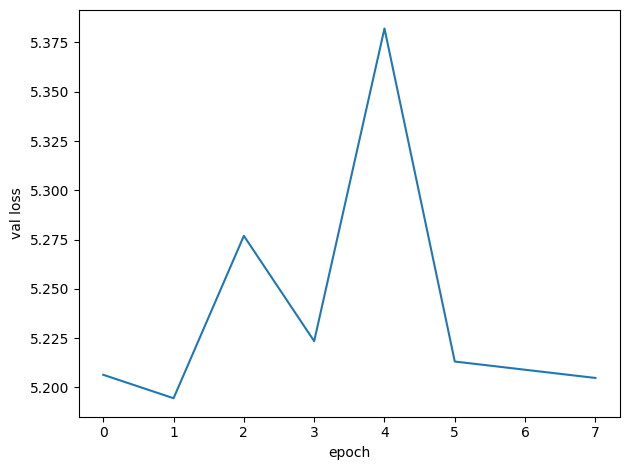

In [32]:
import matplotlib.pyplot as plt

x = range(len(val_losses))
y = val_losses

plt.figure()
plt.plot(x, y)
plt.xlabel('epoch')
plt.ylabel('val loss')
# plt.xticks(x, [str(i) for i in y], rotation=90)

#set parameters for tick labels
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tight_layout()

# save plot
plt.savefig('sepsis_pretext_large_val_loss.png')
plt.show()

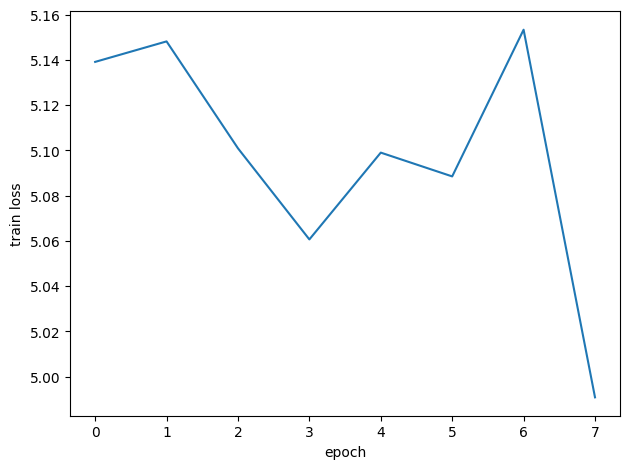

In [34]:
x = range(len(train_losses))
y = train_losses

plt.figure()
plt.plot(x, y)
plt.xlabel('epoch')
plt.ylabel('train loss')
# plt.xticks(x, [str(i) for i in y], rotation=90)

#set parameters for tick labels
plt.tick_params(axis='x', which='major', labelsize=10)
plt.tight_layout()

# save plot
plt.savefig('sepsis_pretext_large_train_loss.png')
plt.show()

## Target Task

Fine-tune: binary classification

#### training

In [ ]:
repeats = {k:10 for k in [10,20,30,40,50,60]}
lds = [10,20,30,40,50]
batch_size, lr, patience = 32, 0.0005, 10
d, N, he, dropout = 50,2,4,0.2
fore_savepath = 'mimic_iii_24h_strats_no_interp_with_ss_fore.h5'
f = open('log.csv', 'a+')
f.write('\nTraining on different % of labeled data\n')

train_inds = np.arange(len(train_op))
valid_inds = np.arange(len(valid_op))
gen_res = {}

np.random.seed(2021)
for ld in lds:
    np.random.shuffle(train_inds)
    np.random.shuffle(valid_inds)
    train_starts = [int(i) for i in np.linspace(0, len(train_inds)-int(ld*len(train_inds)/100), repeats[ld])]
    valid_starts = [int(i) for i in np.linspace(0, len(valid_inds)-int(ld*len(valid_inds)/100), repeats[ld])]
    f.write('Training on '+str(ld)+' % of labaled data+\n'+'val_metric,roc_auc,pr_auc,min_rp,savepath\n')
    all_test_res = []
    for i in range(repeats[ld]):
        print ('Repeat', i, 'ld', ld)
        # Get train and validation data.
        curr_train_ind = train_inds[np.arange(train_starts[i], train_starts[i]+int(ld*len(train_inds)/100))]
        curr_valid_ind = valid_inds[np.arange(valid_starts[i], valid_starts[i]+int(ld*len(valid_inds)/100))]
        curr_train_ip = [ip[curr_train_ind] for ip in train_ip]
        curr_valid_ip = [ip[curr_valid_ind] for ip in valid_ip]
        curr_train_op = train_op[curr_train_ind]
        curr_valid_op = valid_op[curr_valid_ind]
        print ('Num train:',len(curr_train_op),'Num valid:',len(curr_valid_op))
        # Construct save_path.
        savepath = 'new_mimic_iii_24hm_strats_no_interp_with_ss_repeat'+str(i)+'_'+str(ld)+'ld'+'.h5'
        print (savepath)
        # Build and compile model.
        model, fore_model =  build_strats(D, max_len, V, d, N, he, dropout, forecast=True)
        model.compile(loss=mortality_loss, optimizer=Adam(lr))
        fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))
        # Load pretrained weights here.
        fore_model.load_weights(fore_savepath)
        # Train model.
        es = EarlyStopping(monitor='custom_metric', patience=patience, mode='max', 
                           restore_best_weights=True)
        cus = CustomCallback(validation_data=(curr_valid_ip, curr_valid_op), batch_size=batch_size)
        his = model.fit(curr_train_ip, curr_train_op, batch_size=batch_size, epochs=1000,
                        verbose=1, callbacks=[cus, es]).history
        model.save_weights(savepath)
        # Test and write to log.
        rocauc, prauc, minrp = get_res(test_op, model.predict(test_ip, verbose=0, batch_size=batch_size))
        f.write(str(np.min(his['custom_metric']))+str(rocauc)+str(prauc)+str(minrp)+savepath+'\n')
        print ('Test res', rocauc, prauc, minrp)
        all_test_res.append([rocauc, prauc, minrp])
        
    gen_res[ld] = []
    for i in range(len(all_test_res[0])):
        nums = [test_res[i] for test_res in all_test_res]
        gen_res[ld].append((np.mean(nums), np.std(nums)))
    print ('gen_res', gen_res)
f.close()

# # save to local
# log_path = '/content/log.csv'
# files.download(log_path)

Repeat 0 ld 10
Num train: 3655 Num valid: 926
new_mimic_iii_24hm_strats_no_interp_with_ss_repeat0_10ld.h5


2023-03-10 15:27:12.137465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 15:27:14.776253: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30940 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3a:00.0, compute capability: 7.0
2023-03-10 15:27:14.776923: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30926 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-03-10 15:27:14.777468: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/rep

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Epoch 1/1000


2023-03-10 15:27:26.897345: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1466f807abd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-10 15:27:26.897375: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-03-10 15:27:26.897380: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-03-10 15:27:26.897384: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-03-10 15:27:26.897388: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (3): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-03-10 15:27:26.904470: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-10 15:

115/115 [==============================] - 17s 67ms/step - loss: 0.5272 - custom_metric: 1.2631
Epoch 2/1000
115/115 [==============================] - 6s 50ms/step - loss: 0.4171 - custom_metric: 1.2837
Epoch 3/1000
115/115 [==============================] - 5s 48ms/step - loss: 0.3999 - custom_metric: 1.3438
Epoch 4/1000
115/115 [==============================] - 5s 46ms/step - loss: 0.3727 - custom_metric: 1.3305
Epoch 5/1000
115/115 [==============================] - 5s 47ms/step - loss: 0.3458 - custom_metric: 1.3144
Epoch 6/1000
115/115 [==============================] - 5s 45ms/step - loss: 0.2951 - custom_metric: 1.3237
Epoch 7/1000
115/115 [==============================] - 5s 47ms/step - loss: 0.2655 - custom_metric: 1.2600
Epoch 8/1000
115/115 [==============================] - 5s 46ms/step - loss: 0.2465 - custom_metric: 1.2635
Epoch 9/1000
115/115 [==============================] - 5s 46ms/step - loss: 0.2157 - custom_metric: 1.2697
Epoch 10/1000
115/115 [=================

In [29]:
repeats = {k:10 for k in [10,20,30,40,50,60]}
repeats[50]

10

In [31]:
# repeats = {k:10 for k in [10,20,30,40,50,60]}
# lds = [10,20,30,40,50]
batch_size, lr, patience = 32, 0.0005, 10
d, N, he, dropout = 50,2,4,0.2
fore_savepath = 'mimic_iii_24h_strats_no_interp_with_ss_fore.h5'
# f = open('log.csv', 'a+')
# f.write('\nTraining on different % of labeled data\n')

train_inds = np.arange(len(train_op))
valid_inds = np.arange(len(valid_op))
# gen_res = {}

np.random.seed(2021)

ld = 50
i = 9

np.random.shuffle(train_inds)
np.random.shuffle(valid_inds)
train_starts = [int(i) for i in np.linspace(0, len(train_inds)-int(ld*len(train_inds)/100), repeats[ld])]
valid_starts = [int(i) for i in np.linspace(0, len(valid_inds)-int(ld*len(valid_inds)/100), repeats[ld])]
# f.write('Training on '+str(ld)+' % of labaled data+\n'+'val_metric,roc_auc,pr_auc,min_rp,savepath\n')
all_test_res = []
print ('Repeat', i, 'ld', ld)
# Get train and validation data.
curr_train_ind = train_inds[np.arange(train_starts[i], train_starts[i]+int(ld*len(train_inds)/100))]
curr_valid_ind = valid_inds[np.arange(valid_starts[i], valid_starts[i]+int(ld*len(valid_inds)/100))]
curr_train_ip = [ip[curr_train_ind] for ip in train_ip]
curr_valid_ip = [ip[curr_valid_ind] for ip in valid_ip]
curr_train_op = train_op[curr_train_ind]
curr_valid_op = valid_op[curr_valid_ind]
print ('Num train:',len(curr_train_op),'Num valid:',len(curr_valid_op))
# Construct save_path.
savepath = 'new_mimic_iii_24hm_strats_no_interp_with_ss_repeat'+str(i)+'_'+str(ld)+'ld'+'.h5'
print (savepath)
# Build and compile model.
model, fore_model =  build_strats(D, max_len, V, d, N, he, dropout, forecast=True)
model.compile(loss=mortality_loss, optimizer=Adam(lr))
fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))
# Load pretrained weights here.
fore_model.load_weights(fore_savepath)
# Train model.
es = EarlyStopping(monitor='custom_metric', patience=patience, mode='max', 
                   restore_best_weights=True)
cus = CustomCallback(validation_data=(curr_valid_ip, curr_valid_op), batch_size=batch_size)
his = model.fit(curr_train_ip, curr_train_op, batch_size=batch_size, epochs=1000,
                verbose=1, callbacks=[cus, es]).history
model.save_weights(savepath)
# Test and write to log.
rocauc, prauc, minrp = get_res(test_op, model.predict(test_ip, verbose=0, batch_size=batch_size))
# f.write(str(np.min(his['custom_metric']))+str(rocauc)+str(prauc)+str(minrp)+savepath+'\n')
print ('Test res', rocauc, prauc, minrp)
all_test_res.append([rocauc, prauc, minrp])

#     gen_res[ld] = []
#     for i in range(len(all_test_res[0])):
#         nums = [test_res[i] for test_res in all_test_res]
#         gen_res[ld].append((np.mean(nums), np.std(nums)))
#     print ('gen_res', gen_res)
# f.close()

Repeat 9 ld 50
Num train: 18275 Num valid: 4631
new_mimic_iii_24hm_strats_no_interp_with_ss_repeat9_50ld.h5
Epoch 1/1000
572/572 [==============================] - 34s 49ms/step - loss: 0.4658 - custom_metric: 1.3563
Epoch 2/1000
572/572 [==============================] - 26s 45ms/step - loss: 0.4129 - custom_metric: 1.4064
Epoch 3/1000
572/572 [==============================] - 25s 45ms/step - loss: 0.3975 - custom_metric: 1.4084
Epoch 4/1000
572/572 [==============================] - 25s 44ms/step - loss: 0.3823 - custom_metric: 1.3925
Epoch 5/1000
572/572 [==============================] - 25s 44ms/step - loss: 0.3679 - custom_metric: 1.3971
Epoch 6/1000
572/572 [==============================] - 25s 44ms/step - loss: 0.3523 - custom_metric: 1.3294
Epoch 7/1000
572/572 [==============================] - 25s 44ms/step - loss: 0.3399 - custom_metric: 1.3778
Epoch 8/1000
572/572 [==============================] - 25s 44ms/step - loss: 0.3230 - custom_metric: 1.3383
Epoch 9/1000
572/572

#### visualization

In [ ]:
x= range(10,51,10)
for i,metric in enumerate(['ROC-AUC', 'PR-AUC', 'min(Re,Pr)']):
    plt.figure()
    y = [gen_res[ld][i][0] for ld in x]
    plt.plot(x, y, color='r', marker='^')
    plt.xlabel('% labeled data')
    plt.ylabel(metric)
    # save plt
    plt.savefig(metric+'.png')    